In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import sys
sys.path.append('../../')

from flow_solver.finite_element_model import FEM
from flow_solver.mesh_generator_rec import MeshDoublePipe
from problems.topo_opt_level_set_fluid_flow import TopologyOptimizationParameterTuning
from optimizer import Annealing, AnnealingSolver, PolyTop, AnnealingParameterTuning

# Timeout Analysis for Double Pipe problem

## Computational Mesh

In [2]:
# Create Meshes for double pipe.
n_elem_for_width = 48
n_elem_for_height = 32

mesh_v = MeshDoublePipe('Q2', n_elem_for_width, n_elem_for_height)
mesh_p = MeshDoublePipe('Q1', n_elem_for_width, n_elem_for_height)

if n_elem_for_width < 5:
    mesh_v.plot()
    mesh_p.plot()

## Finite Element Model

### Boundary Condition 

In [3]:
def upper_inlet_velocity(mesh, i_node):
    x = mesh.coords[i_node][0]; y = mesh.coords[i_node][1]
    v_x = 1-144*((y-3/4)**2); v_y = 0.0
    return np.array([v_x, v_y])

In [4]:
def lower_inlet_velocity(mesh, i_node):
    x = mesh.coords[i_node][0]; y = mesh.coords[i_node][1]
    v_x = 1-144*((y-1/4)**2); v_y = 0.0
    return np.array([v_x,v_y])

In [5]:
# Compute boundary velocities.
width =1/3
boundary_velocity = {key: [] for key in mesh_v.boundary_nodes.keys()}
for boundary in mesh_v.boundary_nodes.keys():
    for i_node in mesh_v.boundary_nodes[boundary]:
        if boundary == 'inlet_upper':
            boundary_velocity[boundary].append(upper_inlet_velocity(mesh_v, i_node))
        elif boundary == 'inlet_lower':
            boundary_velocity[boundary].append(lower_inlet_velocity(mesh_v, i_node))
        elif boundary == 'wall':
            boundary_velocity[boundary].append(np.zeros(2))

# Set values for Dirichlet boundary conditions.
# Velocity.
BC = []
for boundary in mesh_v.boundary_nodes.keys():
    for i_node, node in enumerate(mesh_v.boundary_nodes[boundary]):
        if boundary == 'inlet_upper' or boundary == 'inlet_lower' or boundary == 'wall' :
            BC.append([node, 0, boundary_velocity[boundary][i_node][0]])
            BC.append([node, 1, boundary_velocity[boundary][i_node][1]])
boundary_values_v = np.array(BC)

# Pressure.
BC = []
for boundary in mesh_p.boundary_nodes.keys():
    for i_node, node in enumerate(mesh_p.boundary_nodes[boundary]):
        if boundary == 'inlet_upper' or boundary == 'wall':
            pass
boundary_values_p= np.array(BC)

### Material Properties

In [6]:
viscosity = 1.0; 
density = 1

### Finite Element Model

In [7]:
fem = FEM(mesh_v, mesh_p, viscosity, density)
fem.set_boudary_values_v(boundary_values_v)

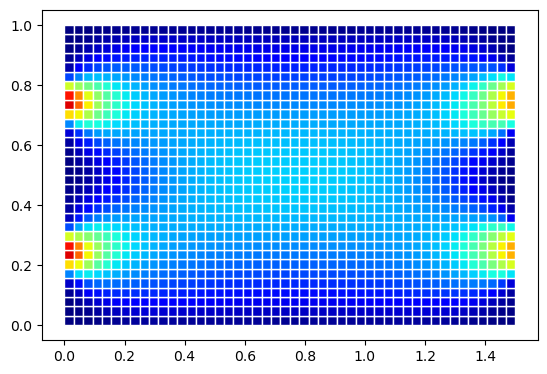

In [8]:
U, u_e, v_e, p_e, F, f=fem.solve()
coords, elements, boundary_nodes, neighbor_elements=mesh_p.create_mesh_Q1(n_elem_for_width, n_elem_for_height, 1.5, 1.)
from flow_solver import Q2Q1FEM
Q2Q1FEM.Plot_patch(n_elem_for_height,coords,elements,np.sqrt(u_e**2+v_e**2),1.,0,cmap='jet')

## Timeout analysis

In [9]:
from amplify.client import FixstarsClient
client = FixstarsClient()
client.parameters.timeout = 10000
client.parameters.outputs.duplicate = True
client.token = 'token '
#client.proxy = ''

annealing_solver = AnnealingSolver(client)

In [10]:
dis = 1.
reg = 2.
char = 25.
vol = 160.
n_qubits_per_variable = 9
volume_fraction_max = 1/3

In [11]:
problem = TopologyOptimizationParameterTuning(fem.ne, n_qubits_per_variable)
problem.generate_discretizaton()
problem.generate_qubo_formulation(u_e, v_e, dis, reg, char, vol, volume_fraction_max, fem.mesh_v.neighbor_elements)
solution, history = annealing_solver.solve_timeout_analysis(problem)

### Evaluation

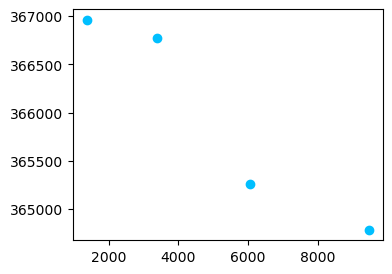

In [21]:
time=history['sampling_time']
energy=history['energy']
plt.figure(figsize=(4,3))
plt.plot(time,energy,linestyle='None', marker='o',color='deepskyblue')
plt.show()